#### Navigate to directory containing .mat data.

In [1]:
cd ../_data/matlabData/

/home/gustav/Documents/DD142X/code/_data/matlabData


#### Function definitions for data extraction and feature extraction.
Basic imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from h5py import File
def getMatlabValues(fileName):
    with File(fileName, "r") as data:
        return {
            key: np.array(data[key]["values"]).flatten() for key in data.keys()
        }

# Fourier Feature Vector
def ffv(xs, Fs = 16000., epoch_size = 2 ** 11, fft_n = 2 ** 14):

    # Pad with zeroes for more frequency outputs
    # Compare np.fft.fftfreq(n, 1/16000) for n = 2**11, 2**14
    fft_in = np.zeros((xs.shape[0], fft_n))
    fft_in[ : , 0:epoch_size] = xs

    frqs = np.fft.fftfreq(fft_n, 1./Fs)
    lo = np.where(frqs > 12)[0][0]
    hi = np.where(frqs > 30)[0][0]
    fftxs = np.abs(np.fft.fft(fft_in)[:,lo:hi])

    return fftxs, frqs[lo:hi]

#### I/O

In [3]:
mlDict = getMatlabValues("NPR-075.b11.mat")

vals_str = np.array([v for k, v in mlDict.items() if "str_lfp" in k])
vals_gp  = np.array([v for k, v in mlDict.items() if "gp_lfp"  in k])
vals_all = np.concatenate((vals_str, vals_gp), axis = 0)

print(vals_str.shape)
print(vals_gp.shape)
print(vals_all.shape)

(11, 1587696)
(15, 1587696)
(26, 1587696)


#### First, consider PCA of "raw" data.
Trim excess datapoints in order to work with 2^n length epochs.

In [4]:
print( vals_str.shape[1] / 2 ** 14 )
print(  2 ** 14 / 16000 )

96.9052734375
1.024


2 ** 14 seems like a reasonable maximum epoch size.

In [4]:
vals_str = vals_str[ : , 0 : 2 ** 14 * 96]
vals_gp  = vals_gp [ : , 0 : 2 ** 14 * 96]
vals_all = vals_all[ : , 0 : 2 ** 14 * 96]

print(vals_str.shape)
print(vals_gp.shape)
print(vals_all.shape)

(11, 1572864)
(15, 1572864)
(26, 1572864)


#### Consider amount of required principal components to explain variance to some degree.

In [5]:
from sklearn.decomposition import PCA

In [6]:
print("### PCA explained variance ratio per component and sum, n_components = 10")
for epoch_size in [
    2 ** 14, 2 ** 13, # ~1s, 0.5s
    2 ** 12, 2 ** 11, # ~0.25s, 0.125s
    2 ** 10, 2 ** 9   # Very short, may cause memory issues - hardly optimized
]:
    # Investigate for large n_components
    print("### Epoch size " + str(epoch_size))
    pca_str = PCA(n_components = 10).fit(vals_str.copy().reshape((-1, epoch_size)))
    pca_gp  = PCA(n_components = 10).fit(vals_gp.copy().reshape((-1, epoch_size)))
    pca_all = PCA(n_components = 10).fit(vals_all.copy().reshape((-1, epoch_size)))
    print("\tStriatum")
    print(pca_str.explained_variance_ratio_)
    print(pca_str.explained_variance_ratio_.sum())
    print("\tGlobus pallidus")
    print(pca_gp.explained_variance_ratio_)
    print(pca_gp.explained_variance_ratio_.sum())
    print("\tAll")
    print(pca_all.explained_variance_ratio_)
    print(pca_all.explained_variance_ratio_.sum())
    print()

### PCA explained variance ratio per component and sum, n_components = 10
### Epoch size 16384
	Striatum
[0.13201564 0.09549128 0.08267939 0.0709507  0.06386331 0.05941619
 0.0441119  0.03142206 0.02750077 0.02364689]
0.6310981324612782
	Globus pallidus
[0.13970142 0.09407339 0.08341252 0.05959512 0.05431434 0.04960502
 0.04085061 0.03476214 0.02840412 0.02579094]
0.6105096224726172
	All
[0.13595805 0.09411479 0.08162108 0.06524052 0.05891072 0.05358219
 0.042126   0.03069342 0.02821657 0.02719611]
0.6176594566224749

### Epoch size 8192
	Striatum
[0.15187149 0.12482922 0.1079342  0.09913861 0.08795753 0.05288573
 0.03481608 0.01860033 0.01585445 0.01430033]
0.7081879735368989
	Globus pallidus
[0.15902287 0.11923743 0.10791143 0.08742827 0.07933465 0.0506975
 0.03192745 0.02011303 0.01736944 0.01659321]
0.6896352840702308
	All
[0.154862   0.11412229 0.1134704  0.09218164 0.0860637  0.05165942
 0.03317962 0.01921956 0.01633587 0.01554335]
0.6966378533319907

### Epoch size 4096
	Striatu

#### At n >= 2048 points per epoch, lots of variance can be explained with very few components
Even at lower greater n, much variance can be explained with somewhat few components. Could be an interesting alternative to fourier transform. High dimensionality (large number of principal components) not a big problem - very large dataset.

The weight of each PC in a resulting PC-based feature vector could be scaled by explained variance ratio, or some other technique along those lines.

#### PCA, however, ignores spectral domain.
This could be problematic. PCA gives information only on "entire" LFP, not beta-range, which we are targeting(?). PCA can be applied to Fourier-transform-based feature vector "ffv".

In [ ]:
# Number of features extracted remains (in this example) constant at 18

print("### PCA explained variance ratio per component and sum, for DFT-based feature vector, n_components = 10")
for epoch_size in [
    2 ** 14, 2 ** 13,
    2 ** 12, 2 ** 11,
    2 ** 10, #2 ** 9   # Greater risk of memory issues, workaround not implemented
]:
    print("### Epoch size " + str(epoch_size))
    ffv_str, _ = ffv(vals_str.reshape((-1, epoch_size)), epoch_size=epoch_size)
    ffv_gp,  _ = ffv(vals_gp.reshape((-1, epoch_size)), epoch_size=epoch_size)
    ffv_all, _ = ffv(vals_all.reshape((-1, epoch_size)), epoch_size=epoch_size)
    
    pca_str = PCA(n_components = 10).fit(ffv_str)
    pca_gp  = PCA(n_components = 10).fit(ffv_gp)
    pca_all = PCA(n_components = 10).fit(ffv_all)
    
    print("\tStriatum")
    print(pca_str.explained_variance_ratio_)
    print(pca_str.explained_variance_ratio_.sum())
    print("\tGlobus pallidus")
    print(pca_gp.explained_variance_ratio_)
    print(pca_gp.explained_variance_ratio_.sum())
    print("\tAll")
    print(pca_all.explained_variance_ratio_)
    print(pca_all.explained_variance_ratio_.sum())
    print()
    
    

### PCA explained variance ratio per component and sum, for DFT-based feature vector, n_components = 10
### Epoch size 16384
	Striatum
[0.1282068  0.10920921 0.09645611 0.08493102 0.07250854 0.06865115
 0.06047625 0.05241997 0.04776931 0.0458104 ]
0.7664387619805519
	Globus pallidus
[0.12801003 0.11145797 0.1017971  0.08601633 0.08069299 0.06828279
 0.06331946 0.05063642 0.04935059 0.0448874 ]
0.7844510793717202
	All
[0.12412244 0.10926272 0.10029431 0.08297152 0.07811252 0.06657244
 0.0614023  0.05190005 0.05048729 0.04812489]
0.7732504782016221

### Epoch size 8192
	Striatum
[0.1748784  0.12133393 0.10323539 0.08420862 0.08053167 0.06975029
 0.05514768 0.05259114 0.04747176 0.04044812]
0.8295969892428826
	Globus pallidus
[0.60077462 0.0662128  0.05387123 0.03661241 0.03646467 0.03411644
 0.03013468 0.02531864 0.02213112 0.01950109]
0.9251377003498068
	All
[0.1725584  0.12378346 0.11180106 0.08366169 0.07423475 0.06750929
 0.06530015 0.05014109 0.04681424 0.04113517]
0.836939285818716

#### Good potential for feature reduction for sufficiently short epoch sizes. 
10 components do a very good job at n = 4096. 6 components good enough for ~85% variance.
6 components do a very good job at n = 2048. 4 components good enough for >90% variance.
At n = 1024, 2 components ~85% variance. 3 components >90%.
Memory issues at n = 512. Workaround pending.

If used as feature vectors, should take explained variance ratio into account (as previously discussed).

In [6]:
ffv_all, _ = ffv(
        vals_all.reshape((-1, 1024)),
        epoch_size = 1024
    )
pca_plot = PCA(n_components=2).fit(ffv_all)
embeddings = pca_plot.transform(ffv_all)

# 26 channels * n epochs * 2 principal components
embeddings = embeddings.reshape((26, -1, 2))

# Split into channel groups
str_tmp = embeddings[0:11 , : , : ]
gp_tmp  = embeddings[11:26, : , : ]

<Figure size 432x288 with 0 Axes>

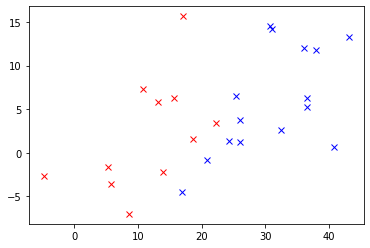

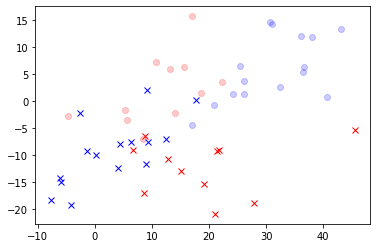

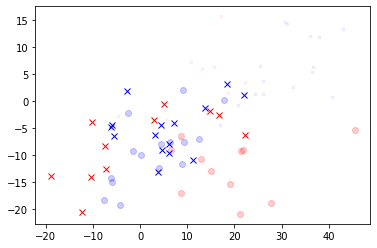

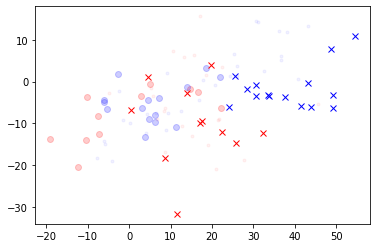

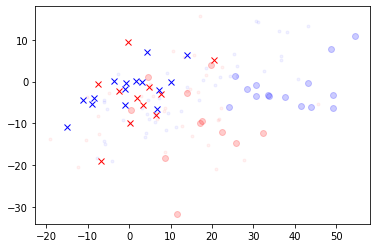

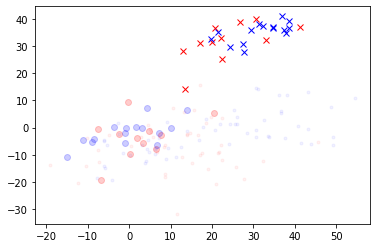

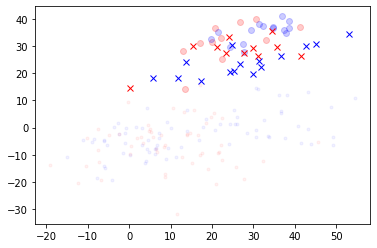

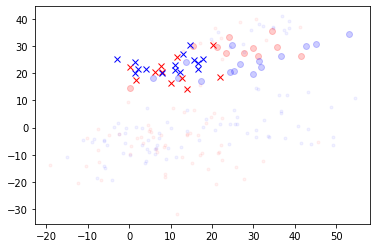

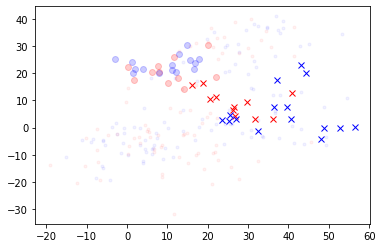

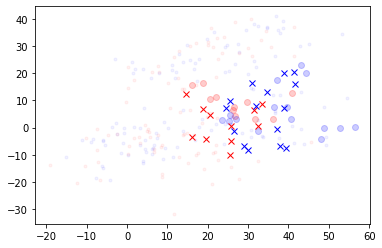

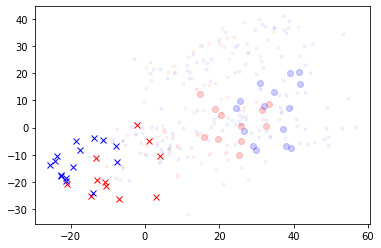

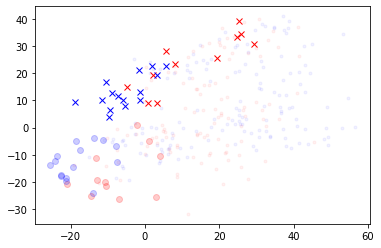

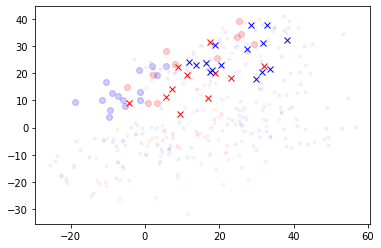

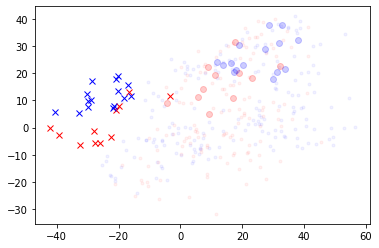

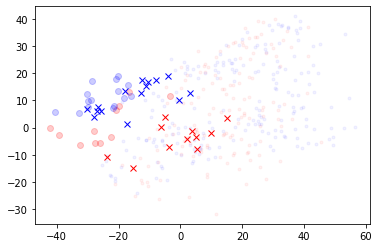

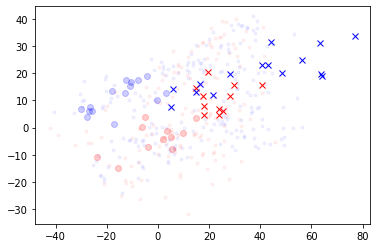

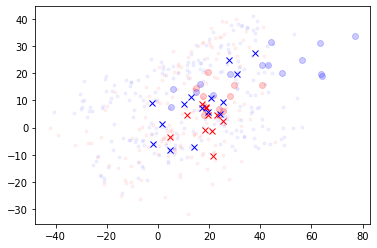

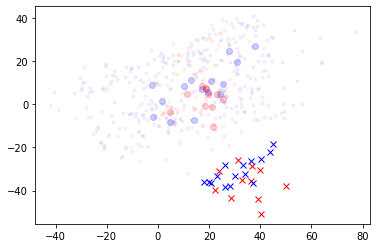

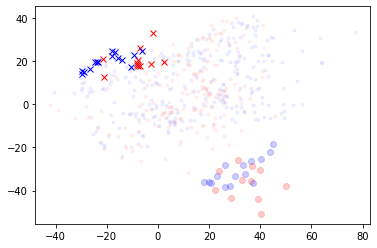

In [9]:
EPOCH_MAX = 20

plt.clf()
for hi in range(0, EPOCH_MAX):
    for ep in range(0, hi):
        
        alpha = 0.05
        shape = '.'
        if ep == hi - 1:
            alpha = 1
            shape = 'x'
        elif ep == hi - 2:
            shape = 'o'
            alpha = 0.2
            
        plt.plot(
            [x for x,_ in str_tmp[ : , ep]], 
            [y for _,y in str_tmp[ : , ep]], 
            'r' + shape,
            alpha=alpha
        )
        
        plt.plot(
            [x for x,_ in gp_tmp[ : , ep]], 
            [y for _,y in gp_tmp[ : , ep]], 
            'b' + shape,
            alpha=alpha
        )
    plt.show()

#### Data seems to move "together in a cloud", though consistently slightly separate per-channel-type.
Similar results as use of TSNE.

#### Attempt to rasterize PCA

In [7]:
# Hard to understand but efficient function.
# Written in a "pythonic" (simpler) rather than "numpythonic" way, takes many many MANY times longer.
def rasterize(samples, side = 40):
    # Find range of values; input is N x 2 numpy array
    maxx1 = np.max(samples[ : , 0])
    minx1 = np.min(samples[ : , 0])
    maxx2 = np.max(samples[ : , 1])
    minx2 = np.min(samples[ : , 1])
    
    # Decides the "pixels"
    x1incr = (maxx1 - minx1) / side
    x2incr = (maxx2 - minx2) / side
    raster = np.zeros((side, side))
    
    # Count amount of samples belonging to each pixel
    for i in range(0, side):
        for j in range(0, side):
            # 
            #    Uses numpy boolean indexing
            #
            raster[i,j] += samples[
                (samples[ : , 0] >= minx1 + i * x1incr) & \
                (samples[ : , 0] < minx1 + (i + 1) * x1incr) & \
                (samples[ : , 1] >= minx2 + j * x2incr) & \
                (samples[ : , 1] < minx2 + (j + 1) * x2incr)
            ].flatten().shape[0]
            
    return raster

[0.58872963 0.30003181]


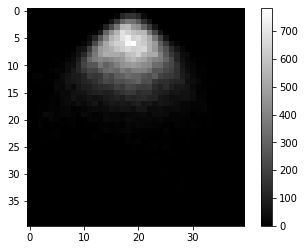

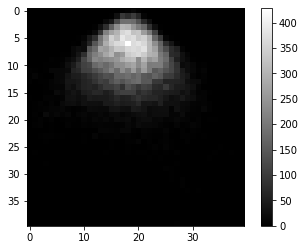

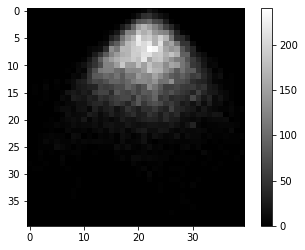

In [9]:
print(pca_plot.explained_variance_ratio_)

raster_all = rasterize(embeddings.reshape((-1, 2)))
plt.imshow(raster_all, cmap = 'gray', vmin = 0, vmax = np.max(raster_all))
plt.colorbar()
plt.show()

raster_gp = rasterize(gp_tmp.reshape((-1, 2)))
plt.imshow(raster_gp, cmap = 'gray', vmin = 0, vmax = np.max(raster_gp))
plt.colorbar()
plt.show()

raster_str = rasterize(str_tmp.reshape((-1, 2)))
plt.imshow(raster_str, cmap = 'gray', vmin = 0, vmax = np.max(raster_str))
plt.colorbar()
plt.show()